In [1]:
import numpy as np
from datasets import Dataset
from PIL import Image
import pathlib
from transformers import SamProcessor
from transformers import SamModel, SamConfig
from torch.utils.data import DataLoader
from patchify import patchify
import os
import torch
from torch.optim import Adam
import monai
from transformers import SamModel, SamProcessor
import train.fishLoader as fish
import train.dataset_proc as ppf
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import logging
import platform
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import DBSCAN

/Users/huizhizhang/anaconda3/envs/FISH/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: partially initialized module 'cv2' has no attribute 'dnn' (most likely due to a circular import)

In [7]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def plt_result(result, img):
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.axis('off')
    show_anns(result)

def get_top_brightness_points(np_image, percentage):
    grayscale_image = np.mean(np_image, axis=2)
    threshold_value = np.percentile(grayscale_image, 100 - percentage)
    bright_areas_mask = grayscale_image > threshold_value
    return bright_areas_mask

def appl_exp(ori):
    exposure_factor = 18
    exposed_image_array = np.clip(ori * exposure_factor, 0, 65535)
    return exposed_image_array

def cluster_points(points, eps=3, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = db.labels_
    unique_labels = set(labels)
    clusters = [points[labels == k] for k in unique_labels if k != -1]
    return clusters

def get_bounding_box(points):
    min_x = np.min(points[:, 1])
    max_x = np.max(points[:, 1])
    min_y = np.min(points[:, 0])
    max_y = np.max(points[:, 0])
    return [min_x, min_y, max_x, max_y]

def grayscale_to_rgb(grayscale_imgs):
    # Initialize an empty array to hold the RGB images
    # The new shape will have an extra dimension for the channels at the end
    rgb_imgs = np.zeros(
        (grayscale_imgs.shape[0], grayscale_imgs.shape[1], 3),
        dtype=np.uint8,
    )

    grayscale_img_uint8 = (grayscale_imgs / 256).astype(np.uint8)
    rgb_imgs = np.stack((grayscale_img_uint8,) * 3, axis=-1)

    return rgb_imgs

In [8]:
# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
CP = "fish_v2.1.pth"
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel(config=model_config)
model.load_state_dict(torch.load(pathlib.Path("./assets/model/"+CP), map_location=torch.device('cpu')))
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [10]:
# Load image
example_outside = Image.open(pathlib.Path("./assets/tif/1-50_Hong/MAX_KOa_w1-359 DAPI_s032.tif"))
o_array_grey = np.array(example_outside)
patches = patchify(o_array_grey, (256, 256), step=256)
i, j = 1, 2
random_array = patches[i, j]
single_patch = Image.fromarray(random_array)
single_patch = grayscale_to_rgb(np.array(single_patch))
np_image = np.array(single_patch)

In [11]:
# Get top brightness points mask
percentage = 25  # Percentage for top brightest points
bright_areas_mask = get_top_brightness_points(np_image, percentage)

In [12]:
# Convert bright points mask to coordinates
bright_points = np.column_stack(np.where(bright_areas_mask))

# Cluster the bright points
clusters = cluster_points(bright_points)

# Prepare the input points for each cluster
grouped_input_points = [cluster.tolist() for cluster in clusters]

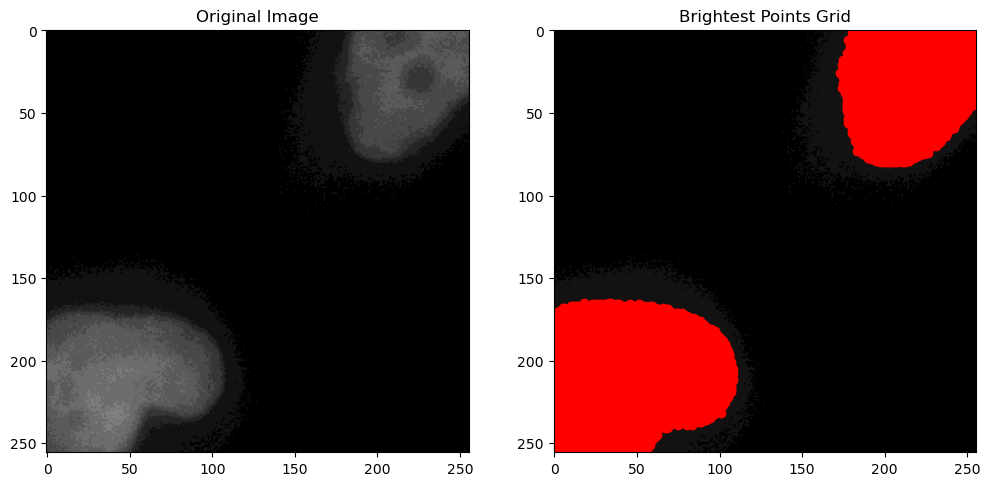

In [13]:
# Visualize the original image and the filtered grid points
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(appl_exp(np_image))

plt.subplot(1, 2, 2)
plt.title("Brightest Points Grid")
plt.imshow(appl_exp(np_image))
for cluster in grouped_input_points:
    for point in cluster:
        plt.plot(point[1], point[0], 'ro')  # Note: (x, y) format for plotting

plt.show()

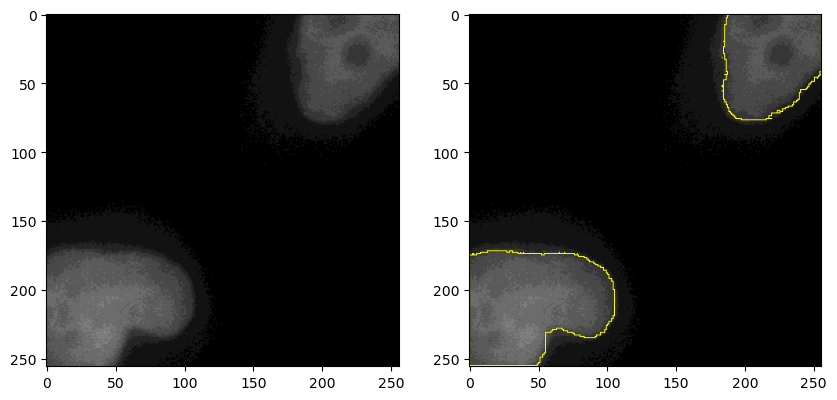

In [26]:
# Generate bounding boxes for each cluster
bounding_boxes = [get_bounding_box(np.array(cluster)) for cluster in grouped_input_points]

# Initialize combined masks
combined_masks = np.zeros_like(np_image[:, :, 0])

# Use the bounding boxes to make predictions
for bbox in bounding_boxes:
    inputs = processor(np_image, input_boxes=[[bbox]], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    medsam_seg_prob = torch.sigmoid(outputs.pred_masks)
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    from scipy.ndimage import binary_erosion
    eroded_mask = binary_erosion(medsam_seg, structure=np.ones((3, 3)))
    medsam_seg = medsam_seg - eroded_mask
    combined_masks = np.maximum(combined_masks, medsam_seg)

fig, axes = plt.subplots(1,2, figsize=(10,5))


axes[0].imshow(appl_exp(np.array(single_patch)), cmap='gray')
axes[1].imshow(appl_exp(np.array(single_patch)), cmap='gray')
overlay = np.zeros((256,256,4), dtype=np.uint8)
overlay[combined_masks == 1] = np.array([255, 255, 0, 255])
axes[1].imshow(overlay)
plt.show()